# Time travel

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We showed how breakpoints can stop the graph at specific nodes or allow the graph to dynamically interrupt itself.

Then we showed how to proceed with human approval or directly edit the graph state with human feedback.

## Goals

Now, let's show how LangGraph [supports debugging](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) by viewing, re-playing, and even forking from past states. 

We call this `time travel`.

In [1]:
import os, getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool


@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


@tool
def subtract(a: int, b: int) -> int:
    """Subtract b from a.

    Args:
        a: first int
        b: second int
    """
    return a - b


tools = [add, multiply, divide, subtract]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [3]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

In [4]:
# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
)


# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

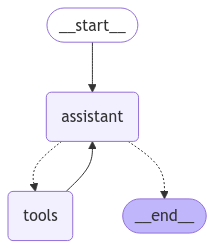

In [5]:
# new graph with interupts
builder = StateGraph(MessagesState)
# define the nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
# define the edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
# add feedback loop
builder.add_edge("tools", "assistant")

# compile the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [28]:
from uuid import uuid4

# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": str(uuid4())}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_sTKlZC5oyppvYlrnaBeICmJK)
 Call ID: call_sTKlZC5oyppvYlrnaBeICmJK
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Browsing History

In [29]:
# We can use `get_state` to look at the **current** state of our graph, given the `thread_id`!
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='173658e5-56c5-458c-a16f-f2900620f9c2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sTKlZC5oyppvYlrnaBeICmJK', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 185, 'total_tokens': 203, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-281867f7-c987-416e-9f0b-186fe7a2f558-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_sTKlZC5oyppvYlrnaBeICmJK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1

We can also browse the state history of our agent.

`get_state_history` lets us get the state at all prior steps.


In [30]:
all_states = [s for s in graph.get_state_history(thread)]
all_states

[StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='173658e5-56c5-458c-a16f-f2900620f9c2'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sTKlZC5oyppvYlrnaBeICmJK', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 185, 'total_tokens': 203, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-281867f7-c987-416e-9f0b-186fe7a2f558-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_sTKlZC5oyppvYlrnaBeICmJK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 

## Replaying 

We can re-run our agent from any of the prior steps.

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)
Let's look back at the step that recieved human input!


In [31]:
to_replay = all_states[-2]
print(to_replay)
# Look at the state.
print(to_replay.values)
# We can see the next node to call.
print(to_replay.next)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='173658e5-56c5-458c-a16f-f2900620f9c2')]}, next=('assistant',), config={'configurable': {'thread_id': 'f0eb89db-ec57-4d26-ba10-86ebfa77d112', 'checkpoint_ns': '', 'checkpoint_id': '1efe7801-4673-6b92-8000-51e2674d4a2d'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': 'f0eb89db-ec57-4d26-ba10-86ebfa77d112', 'step': 0, 'parents': {}}, created_at='2025-02-10T07:24:35.591450+00:00', parent_config={'configurable': {'thread_id': 'f0eb89db-ec57-4d26-ba10-86ebfa77d112', 'checkpoint_ns': '', 'checkpoint_id': '1efe7801-466d-6b92-bfff-03819fa1e62f'}}, tasks=(PregelTask(id='4d3b21b0-8bf3-9228-e6ec-ffc6851f9baa', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sTKlZC5oyppvYlrnaBeICmJK', 'function': {'arguments': '{"a":2,"b":3}', 'nam

In [32]:
# We also get the config, which tells us the `checkpoint_id` as well as the `thread_id`.
to_replay.config

{'configurable': {'thread_id': 'f0eb89db-ec57-4d26-ba10-86ebfa77d112',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe7801-4673-6b92-8000-51e2674d4a2d'}}


To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed. 


In [33]:
# It just re-plays from this checkpoint!

for event in graph.stream(None, config=to_replay.config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_6S7lfQUWuMpmoa5uLhMGmlyp)
 Call ID: call_6S7lfQUWuMpmoa5uLhMGmlyp
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is 6.


So what we are basically doing is replaying from a certain checkpoint

## Forking

What if we want to run from that same step, but with a different input.

This is forking.

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [34]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='173658e5-56c5-458c-a16f-f2900620f9c2')]

In [35]:
to_fork.config
# Let's modify the state at this checkpoint.

{'configurable': {'thread_id': 'f0eb89db-ec57-4d26-ba10-86ebfa77d112',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe7801-4673-6b92-8000-51e2674d4a2d'}}


We can just run `update_state` with the `checkpoint_id` supplied. 

Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

So, to overwrite the the message, we just supply the message ID, which we have `to_fork.values["messages"].id`.


In [36]:
# we can update the state
fork_config = graph.update_state(
    to_fork.config,
    {
        "messages": [
            HumanMessage(
                content="Multiply 5 and 3", id=to_fork.values["messages"][0].id
            )
        ]
    },
)

In [37]:
fork_config

{'configurable': {'thread_id': 'f0eb89db-ec57-4d26-ba10-86ebfa77d112',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe7801-7ac8-6b9b-8001-b84b25e286a5'}}

This creates a new, forked checkpoint.
 
But, the metadata - e.g., where to go next - is perserved! 

We can see the current state of our agent has been updated with our fork.

In [38]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='173658e5-56c5-458c-a16f-f2900620f9c2')]

In [39]:
graph.get_state(thread).values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='173658e5-56c5-458c-a16f-f2900620f9c2')]

In [40]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_GRlCxvzl0m3FlUUGkA6guSI7)
 Call ID: call_GRlCxvzl0m3FlUUGkA6guSI7
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The product of 5 and 3 is 15.


In [41]:
graph.get_state(thread).values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='173658e5-56c5-458c-a16f-f2900620f9c2'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GRlCxvzl0m3FlUUGkA6guSI7', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 185, 'total_tokens': 203, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_50cad350e4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-570ca824-cf0e-4875-b5cb-70bcbf01d9dc-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'call_GRlCxvzl0m3FlUUGkA6guSI7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 185, 'output_tokens': 18, 'total_t

############################################################################## END ##########################################################################